In [84]:
import warnings
import logging
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=RuntimeWarning)
logging.getLogger("dowhy").setLevel(logging.WARNING)
logging.getLogger("pgmpy").setLevel(logging.WARNING)

import tqdm
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import statsmodels.api as sm
from IPython.display import display
from causaldata import social_insure
from pgmpy.estimators.CITests import pillai_trace


df: pd.DataFrame = social_insure.load_pandas().data.dropna()

In [85]:
# Drop fields 'address'
df = df.drop(columns=['address'])

# From social insurance, take takeup_survey
takeup_survey = df['takeup_survey']

## Convert labels to categorical variables

In [86]:
categorical_variables = ['village']
for var in categorical_variables:
    df[var] = df[var].astype('category').cat.codes


# 2.1 Testing correlation / dependence between variables

In [87]:
# For each other variable, calculate the p value of the correlation with takeup_survey
graph1: dict[str, dict[str, bool]] = {}

# Double for loop to compute pillai_trace between each pair of columns
for col1 in tqdm.tqdm(df.columns):
    graph1[col1] = {}
    for col2 in df.columns:
        if col1 == col2:
            continue
        graph1[col1][col2] = pillai_trace(col1, col2, Z=[], data=df, significance_level=0.05)


100%|██████████| 12/12 [00:04<00:00,  2.62it/s]


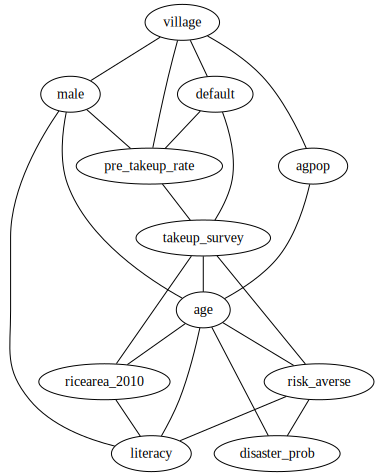

In [88]:
# Create a graph from the p values
G1 = nx.Graph()
for col1 in graph1:
    for col2 in graph1[col1]:
        p_value = graph1[col1][col2]
        if not p_value:
            G1.add_edge(col1, col2)


A = nx.nx_agraph.to_agraph(G1)
A.layout('dot')
A

As can be seen in the above image, the causal links calculated make sense. For example,
 - `age` and `disaster probability` have in no way any correlation.
 - `village` and `male` are uncorrelated.

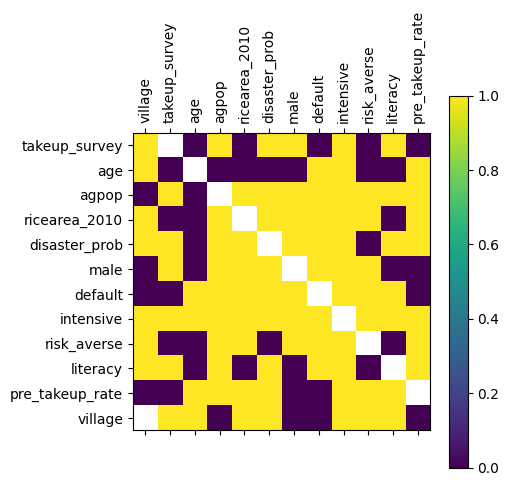

In [89]:
df_confusion_matrix = pd.DataFrame(graph1)
plt.matshow(df_confusion_matrix.replace({True: 1, False: 0}))
plt.xticks(range(len(df_confusion_matrix.columns)), df_confusion_matrix.columns, rotation=90)
plt.yticks(range(len(df_confusion_matrix.index)), df_confusion_matrix.index)
plt.colorbar()
plt.show()

True (1) means indepedent, False (0) means not indepedent

# 2.2 Casual graph
As the true causal graph is unknown, we cooked something up which made sense.

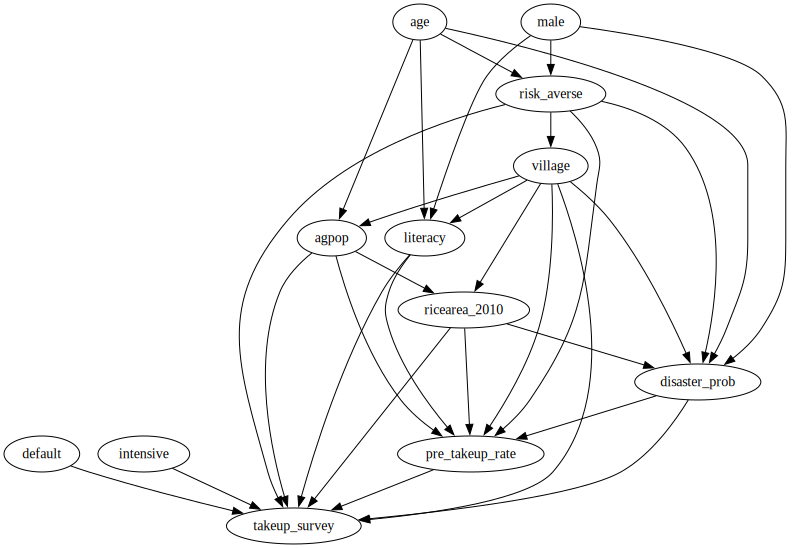

In [90]:
TG = nx.DiGraph()
TG.add_edges_from([
    ('default', 'takeup_survey'),

    ('intensive', 'takeup_survey'),

    ('pre_takeup_rate', 'takeup_survey'),

    ('risk_averse', 'pre_takeup_rate'),
    ('risk_averse', 'takeup_survey'),
    ('risk_averse', 'village'),
    ("risk_averse", "disaster_prob"), # disaster prob is perceived,

    ('disaster_prob', 'pre_takeup_rate'),
    ('disaster_prob', 'takeup_survey'),

    ('literacy', 'pre_takeup_rate'),
    ('literacy', 'takeup_survey'),

    ('village', 'pre_takeup_rate'),
    ('village', 'takeup_survey'),
    ('village', 'literacy'),
    ('village', 'ricearea_2010'),
    ('village', 'disaster_prob'),
    ("village", "agpop"), # certain villages might expect larger families

    ('age', 'agpop'),
    ("age", "literacy"), # older people -> less education (?)
    ("age", "risk_averse"), # older people more risk averse
    ("age", "disaster_prob"), # disaster prob is perceived, so older -> better intuition


    ("agpop", "ricearea_2010"), # larger homes -> more land
    ("agpop", "takeup_survey"), # more security wanted because of family size
    ("agpop", "pre_takeup_rate"), # same as previous

    ("male", "literacy"), # gender gaps in education
    ("male", "risk_averse"), # gender differences in risk attitudes
    ("male", "disaster_prob"), # disaster prob is perceived,

    ("ricearea_2010", "disaster_prob"), # more land -> more chances for disaster
    ("ricearea_2010", "takeup_survey"), # more land -> more at stake
    ("ricearea_2010", "pre_takeup_rate"), # same as previous
    ('ricearea_2010', 'takeup_survey'),
])

A = nx.nx_agraph.to_agraph(TG)
A.layout('dot')
display(A)

# 3. Backdoor, Frontdoor and Instrumental Variables Criteria

In [9]:
from dowhy.causal_identifier import identify_effect
from dowhy import CausalModel


model = CausalModel(
    data=df,
    treatment='risk_averse',
    outcome='takeup_survey',
    graph=TG,
)
print(model.identify_effect())

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                 
─────────────(E[takeup_survey|age,male])
d[riskₐᵥₑᵣₛₑ]                           
Estimand assumption 1, Unconfoundedness: If U→{risk_averse} and U→takeup_survey then P(takeup_survey|risk_averse,age,male,U) = P(takeup_survey|risk_averse,age,male)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

### Estimand : 4
Estimand name: general_adjustment
Estimand expression:
      d                                 
─────────────(E[takeup_survey|age,male])
d[riskₐᵥₑᵣₛₑ]                           
Estimand assumption 1, Unconfoundedness: If U→{risk_averse} and U→takeup_survey then P(takeup_survey|risk_averse,age,male,U) = P(takeup_survey|risk_averse,age,male)



### Conclusions
For the backdoor we condition on Z = {age, male} to find the causal effect of risk_averse on takeup_survey.

There is no frontdoor criterion and no IV either. More details explanation can be found: https://chatgpt.com/share/69297e5a-f860-8008-b9e3-077090a23451

# 4. Estimating Causal Effects
Probably want linear + logistic regression for this, not inverse propensity weighting, two-stage linear regression because for ipw: risk_averse is not binary, no tslr: because no IV instrument

In [10]:
estimate = model.estimate_effect(model.identify_effect(), method_name="backdoor.linear_regression", test_significance=True)
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                 
─────────────(E[takeup_survey|age,male])
d[riskₐᵥₑᵣₛₑ]                           
Estimand assumption 1, Unconfoundedness: If U→{risk_averse} and U→takeup_survey then P(takeup_survey|risk_averse,age,male,U) = P(takeup_survey|risk_averse,age,male)

## Realized estimand
b: takeup_survey~risk_averse+age+male+risk_averse*intensive+risk_averse*default
Target units: 

## Estimate
Mean value: 0.2229288956825206
p-value: [0.02820068]
### Conditional Estimates
__categorical__intensive  __categorical__default
(-0.001, 1.0]             (-0.001, 1.0]             0.222929
dtype: float64


In [11]:
estimate = model.estimate_effect(
    model.identify_effect(),
    method_name="backdoor.generalized_linear_model",
    test_significance=True,
    method_params = {
        'fit_method': "statsmodels",
        'glm_family': sm.families.Binomial(), # logistic regression
        'need_conditional_estimates':False
    }
)
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                 
─────────────(E[takeup_survey|age,male])
d[riskₐᵥₑᵣₛₑ]                           
Estimand assumption 1, Unconfoundedness: If U→{risk_averse} and U→takeup_survey then P(takeup_survey|risk_averse,age,male,U) = P(takeup_survey|risk_averse,age,male)

## Realized estimand
b: takeup_survey~Sigmoid(risk_averse+age+male+risk_averse*intensive+risk_averse*default)
Target units: ate

## Estimate
Mean value: 0.21880717790545406
p-value: [0, 0.001]



## PC
Implementation of the PC algorithm for causal discovery using the `pgmpy` library. We will also define some extra background knowledge to guide the algorithm and improve performance.

In [12]:
from pgmpy.estimators import PC, ExpertKnowledge

pc_calc = PC(data=df.copy())
forbidden_edges = [
]
required_edges = [
    ('takeup_survey', 'risk_averse'),
]

expert_knowledge = ExpertKnowledge(
    forbidden_edges=forbidden_edges,
    required_edges=required_edges,
)

#### Draw the graph obtained with PC algorithm + background knowledge    

In [ ]:
supported_tests = [
    "chi_square",
    "g_sq",
    "log_likelihood",
    "modified_log_likelihood",
    "pearsonr",
    "gcm",
    pillai_trace,
]

for ci_test in supported_tests:
    print(f"Using CI test: {ci_test}")

    pc_graph = pc_calc.estimate(
        ci_test=ci_test,
        # ci_test=pillai_trace,
        # ci_test="pearsonr",
        return_type="cpdag",
        significance_level=0.05,
        expert_knowledge=expert_knowledge,
        enforce_expert_knowledge=True,
    )
    print("Done")

    A = nx.nx_agraph.to_agraph(pc_graph)
    A.layout('dot')
    display(A)


In [ ]:
from pgmpy.estimators import GES

supported_methods = [
    "k2",
    "bdeu",
    "bds",
    "bic-d",
    "aic-d",
    "ll-g",
    "aic-g",
    "bic-g",
    "ll-cg",
    "aic-cg",
    "bic-cg",
]

for method in supported_methods:
    print(f"Estimating GES with scoring method: {method}")
    ges_graph_pgmpy = GES(df.copy()).estimate(scoring_method=method, expert_knowledge=expert_knowledge)

    A = nx.nx_agraph.to_agraph(ges_graph_pgmpy)
    A.layout('dot')
    display(A)

# VALIDATION AND SENSITIVITY ANALYSIS
Report using some of the results of the refutation strategies implemented in DoWhy and interpret what they mean

In [19]:
estimand = model.identify_effect()


In [20]:
refute_random = model.refute_estimate(
    estimand,
    estimate,
    method_name="random_common_cause"
)
print(refute_random)

Refute: Add a random common cause
Estimated effect:0.21880717790545406
New effect:0.21880717790545404
p value:1.0



Adding a completely random “fake confounder” to the model does not change the estimated effect of risk aversion on insurance take-up at all. The estimate is extremely stable to this perturbation, and the p-value of 1.0 indicates no evidence that the added noise has any impact.

In [22]:
refute_subset = model.refute_estimate(
    estimand,
    estimate,
    method_name="data_subset_refuter",
    subset_fraction=0.8,      # use 80% of the data each time
    num_simulations=100       # how many random subsets
)
print(refute_subset)

Refute: Use a subset of data
Estimated effect:0.21880717790545406
New effect:0.21720951593601698
p value:0.96



When we repeatedly re-estimate the effect of risk aversion on take-up using only 80% of the data, the average estimated effect is ~0.220, extremely close to the original 0.219. The high p-value (~0.92) indicates that the difference is not statistically meaningful; the effect is stable across subsamples and not driven by a small subset of observations.

### If your dataset includes interventional data, check that the estimated causal effects from the observational data are reflected in the interventional data

In [98]:
model_default = CausalModel(
    data=df,
    treatment='default',
    outcome='takeup_survey',
    graph=TG  # a DAG where default has no parents (randomized)
)

estimand_default = model_default.identify_effect()
estimate_default = model_default.estimate_effect(
    estimand_default,
    method_name="backdoor.linear_regression",  # or logistic GLM
    test_significance=True
)
print(estimate_default)

import statsmodels.api as sm
import statsmodels.formula.api as smf

logit_default = smf.logit("takeup_survey ~ default", data=df).fit()
print(logit_default.summary())
# You can compute predicted probabilities at default=0 and default=1 and take the difference.



*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                       
──────────(E[takeup_survey])
d[default]                  
Estimand assumption 1, Unconfoundedness: If U→{default} and U→takeup_survey then P(takeup_survey|default,,U) = P(takeup_survey|default,)

## Realized estimand
b: takeup_survey~default+default*age+default*ricearea_2010+default*pre_takeup_rate+default*intensive+default*literacy+default*village+default*disaster_prob+default*male+default*risk_averse+default*agpop
Target units: 

## Estimate
Mean value: 0.06016874442688397
p-value: [1.41467657e-05]
### Conditional Estimates
__categorical__age  __categorical__ricearea_2010  __categorical__pre_takeup_rate  __categorical__intensive  __categorical__literacy  __categorical__village  __categorical__disaster_prob  __categorical__male  __categorical__risk_averse  __categorical__agpop
(17.999, 40.0]      (0.39

ATE: Effect size ≈ 0.06 → going from default = 0 to default = 1
increases the probability of take-up by about 6 percentage points on average. highly significant.

Logistics: Going from default = 0 to 1 increases take-up by ~9–10 p.p., also highly significant.

In [99]:
model_default = CausalModel(
    data=df,
    treatment='intensive',
    outcome='takeup_survey',
    graph=TG  # a DAG where default has no parents (randomized)
)

estimand_default = model_default.identify_effect()
estimate_default = model_default.estimate_effect(
    estimand_default,
    method_name="backdoor.linear_regression",  # or logistic GLM
    test_significance=True
)
print(estimate_default)

import statsmodels.api as sm
import statsmodels.formula.api as smf

logit_default = smf.logit("takeup_survey ~ intensive", data=df).fit()
print(logit_default.summary())
# You can compute predicted probabilities at default=0 and default=1 and take the difference.



*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                        
────────────(E[takeup_survey])
d[intensive]                  
Estimand assumption 1, Unconfoundedness: If U→{intensive} and U→takeup_survey then P(takeup_survey|intensive,,U) = P(takeup_survey|intensive,)

## Realized estimand
b: takeup_survey~intensive+intensive*age+intensive*ricearea_2010+intensive*pre_takeup_rate+intensive*literacy+intensive*default+intensive*village+intensive*disaster_prob+intensive*male+intensive*risk_averse+intensive*agpop
Target units: 

## Estimate
Mean value: -0.006720666791138086
p-value: [2.1559021e-06]
### Conditional Estimates
__categorical__age  __categorical__ricearea_2010  __categorical__pre_takeup_rate  __categorical__literacy  __categorical__default  __categorical__village  __categorical__disaster_prob  __categorical__male  __categorical__risk_averse  __categorical__

Edge Removal Experiments




In [100]:
# Experiment 1: Remove edges one at a time and see impact on identification and estimation

print("="*80)
print("EXPERIMENT 1: Edge Removal Sensitivity Analysis")
print("="*80)

# Get baseline results
baseline_model = CausalModel(
    data=df,
    treatment='risk_averse',
    outcome='takeup_survey',
    graph=TG,
)
baseline_estimand = baseline_model.identify_effect()
baseline_estimate_linear = baseline_model.estimate_effect(
    baseline_estimand,
    method_name="backdoor.linear_regression",
    test_significance=True
)
baseline_estimate_logistic = baseline_model.estimate_effect(
    baseline_estimand,
    method_name="backdoor.generalized_linear_model",
    test_significance=True,
    method_params={
        'fit_method': "statsmodels",
        'glm_family': sm.families.Binomial(),
        'need_conditional_estimates': False
    }
)

# Extract baseline adjustment set
baseline_adj_set = None
estimand_str = str(baseline_estimand)
import re
match = re.search(r'E\[takeup_survey\|([^\]]+)\]', estimand_str)
if match:
    baseline_adj_set = sorted([v.strip() for v in match.group(1).split(',')])

# Helper function to safely extract p-value
def get_pvalue(estimate):
    """Safely extract p-value from CausalEstimate object"""
    if hasattr(estimate, 'p_value') and estimate.p_value is not None and len(estimate.p_value) > 0:
        return estimate.p_value[0]
    elif hasattr(estimate, 'pvalue'):
        return estimate.pvalue
    else:
        # Try to extract from string representation
        estimate_str = str(estimate)
        p_match = re.search(r'p-value:\s*\[([^\]]+)\]', estimate_str)
        if p_match:
            try:
                return float(p_match.group(1).split(',')[0])
            except:
                pass
        return None

baseline_linear_p = get_pvalue(baseline_estimate_linear)
baseline_logistic_p = get_pvalue(baseline_estimate_logistic)

print(f"\nBaseline (Current Graph):")
print(f"  Adjustment Set: {baseline_adj_set}")
baseline_linear_p_str = f"{baseline_linear_p:.4f}" if baseline_linear_p is not None else "N/A"
baseline_logistic_p_str = f"{baseline_logistic_p:.4f}" if baseline_logistic_p is not None else "N/A"
print(f"  Linear ATE: {baseline_estimate_linear.value:.4f} (p={baseline_linear_p_str})")
print(f"  Logistic ATE: {baseline_estimate_logistic.value:.4f} (p={baseline_logistic_p_str})")

# Test removing different edges
edges_to_test = [
    ('risk_averse', 'village', 'risk_averse → village'),
    ('village', 'takeup_survey', 'village → takeup_survey'),
    ('village', 'pre_takeup_rate', 'village → pre_takeup_rate'),
    ('risk_averse', 'pre_takeup_rate', 'risk_averse → pre_takeup_rate'),
    ('disaster_prob', 'takeup_survey', 'disaster_prob → takeup_survey'),
    ('literacy', 'takeup_survey', 'literacy → takeup_survey'),
]

edge_removal_results = []

for edge_to_remove in edges_to_test:
    print(f"\n{'='*80}")
    print(f"Testing: Remove {edge_to_remove[2]}")
    print(f"{'='*80}")
    
    # Create modified graph
    TG_modified = TG.copy()
    if TG_modified.has_edge(edge_to_remove[0], edge_to_remove[1]):
        TG_modified.remove_edge(edge_to_remove[0], edge_to_remove[1])
        
        try:
            # Test identification
            model_modified = CausalModel(
                data=df,
                treatment='risk_averse',
                outcome='takeup_survey',
                graph=TG_modified,
            )
            estimand_modified = model_modified.identify_effect()
            
            # Extract adjustment set
            adj_set_modified = None
            estimand_str_modified = str(estimand_modified)
            match = re.search(r'E\[takeup_survey\|([^\]]+)\]', estimand_str_modified)
            if match:
                adj_set_modified = sorted([v.strip() for v in match.group(1).split(',')])
            
            # Test estimation
            estimate_linear_modified = model_modified.estimate_effect(
                estimand_modified,
                method_name="backdoor.linear_regression",
                test_significance=True
            )
            estimate_logistic_modified = model_modified.estimate_effect(
                estimand_modified,
                method_name="backdoor.generalized_linear_model",
                test_significance=True,
                method_params={
                    'fit_method': "statsmodels",
                    'glm_family': sm.families.Binomial(),
                    'need_conditional_estimates': False
                }
            )
            
            # Compare
            adj_set_changed = adj_set_modified != baseline_adj_set
            linear_ate_changed = abs(estimate_linear_modified.value - baseline_estimate_linear.value) > 0.001
            logistic_ate_changed = abs(estimate_logistic_modified.value - baseline_estimate_logistic.value) > 0.001
            
            linear_p_modified = get_pvalue(estimate_linear_modified)
            logistic_p_modified = get_pvalue(estimate_logistic_modified)
            
            linear_p_modified_str = f"{linear_p_modified:.4f}" if linear_p_modified is not None else "N/A"
            logistic_p_modified_str = f"{logistic_p_modified:.4f}" if logistic_p_modified is not None else "N/A"
            
            print(f"  Adjustment Set: {adj_set_modified}")
            print(f"    Changed? {adj_set_changed}")
            print(f"  Linear ATE: {estimate_linear_modified.value:.4f} (p={linear_p_modified_str})")
            print(f"    Changed? {linear_ate_changed} (Δ={estimate_linear_modified.value - baseline_estimate_linear.value:.4f})")
            print(f"  Logistic ATE: {estimate_logistic_modified.value:.4f} (p={logistic_p_modified_str})")
            print(f"    Changed? {logistic_ate_changed} (Δ={estimate_logistic_modified.value - baseline_estimate_logistic.value:.4f})")
            
            edge_removal_results.append({
                'edge_removed': edge_to_remove[2],
                'adjustment_set': adj_set_modified,
                'adjustment_set_changed': adj_set_changed,
                'linear_ate': estimate_linear_modified.value,
                'linear_p': linear_p_modified,
                'logistic_ate': estimate_logistic_modified.value,
                'logistic_p': logistic_p_modified,
                'linear_ate_change': estimate_linear_modified.value - baseline_estimate_linear.value,
                'logistic_ate_change': estimate_logistic_modified.value - baseline_estimate_logistic.value,
            })
        except Exception as e:
            print(f"  ERROR: {e}")
            edge_removal_results.append({
                'edge_removed': edge_to_remove[2],
                'error': str(e)
            })
    else:
        print(f"  Edge does not exist in graph, skipping...")

# Summary table
print(f"\n{'='*80}")
print("SUMMARY: Edge Removal Impact")
print(f"{'='*80}")
print(f"{'Edge Removed':<30} {'Adj Set Changed':<15} {'Linear Δ':<12} {'Logistic Δ':<12}")
print("-"*80)
for result in edge_removal_results:
    if 'error' not in result:
        adj_changed = "✅ Yes" if result['adjustment_set_changed'] else "❌ No"
        print(f"{result['edge_removed']:<30} {adj_changed:<15} {result['linear_ate_change']:>+10.4f}  {result['logistic_ate_change']:>+10.4f}")
    else:
        print(f"{result['edge_removed']:<30} {'ERROR':<15} {'N/A':<12} {'N/A':<12}")



EXPERIMENT 1: Edge Removal Sensitivity Analysis

Baseline (Current Graph):
  Adjustment Set: ['age', 'male']
  Linear ATE: 0.2229 (p=0.0282)
  Logistic ATE: 0.2188 (p=0.0000)

Testing: Remove risk_averse → village
  Adjustment Set: ['age', 'male']
    Changed? False
  Linear ATE: 0.2113 (p=0.9213)
    Changed? True (Δ=-0.0117)
  Logistic ATE: 0.2016 (p=0.0000)
    Changed? True (Δ=-0.0172)

Testing: Remove village → takeup_survey
  Adjustment Set: ['age', 'male']
    Changed? False
  Linear ATE: 0.2229 (p=0.0282)
    Changed? False (Δ=0.0000)
  Logistic ATE: 0.2188 (p=0.0000)
    Changed? False (Δ=0.0000)

Testing: Remove village → pre_takeup_rate
  Adjustment Set: ['age', 'male']
    Changed? False
  Linear ATE: 0.2229 (p=0.0282)
    Changed? False (Δ=0.0000)
  Logistic ATE: 0.2188 (p=0.0000)
    Changed? False (Δ=0.0000)

Testing: Remove risk_averse → pre_takeup_rate
  Adjustment Set: ['age', 'male']
    Changed? False
  Linear ATE: 0.2229 (p=0.0282)
    Changed? False (Δ=0.0000)
  L

# Relaxing Assumptions

This section tests what happens when we assume certain variables are unobserved.



In [96]:
print("="*80); print("EXPERIMENT 2: Unobserved Variables (Relaxing Assumptions)"); print("="*80)

variables_to_hide = [
    ('village', 'village'),
    ('age', 'age'),
    ('male', 'male'),
    ('literacy', 'literacy'),
    ('disaster_prob', 'disaster_prob'),
    ('pre_takeup_rate', 'pre_takeup_rate'),
]

unobserved_results = []

for var_name, var_display in variables_to_hide:
    print(f"\n{'='*80}")
    print(f"Testing: {var_display} is UNOBSERVED")
    print(f"{'='*80}")

    df_unobserved = df.drop(columns=[var_name])
    TG_unobserved = TG.copy()
    TG_unobserved.remove_edges_from([e for e in TG_unobserved.edges() if var_name in e])

    try:
        model_unobserved = CausalModel(
            data=df_unobserved,
            treatment='risk_averse',
            outcome='takeup_survey',
            graph=TG_unobserved,
        )
        estimand_unobserved = model_unobserved.identify_effect()
        estimand_str_unobserved = str(estimand_unobserved)
        match = re.search(r'E\[takeup_survey\|([^\]]+)\]', estimand_str_unobserved)
        if match:
            adj_set_unobserved = sorted(v.strip() for v in match.group(1).split(','))
        elif "No such variable" in estimand_str_unobserved or "not found" in estimand_str_unobserved.lower():
            adj_set_unobserved = "IDENTIFICATION FAILED"
        else:
            adj_set_unobserved = None

        print(f"  Adjustment Set: {adj_set_unobserved}")

        if adj_set_unobserved != "IDENTIFICATION FAILED":
            estimate_linear_unobserved = model_unobserved.estimate_effect(
                estimand_unobserved,
                method_name="backdoor.linear_regression",
                test_significance=True
            )
            estimate_logistic_unobserved = model_unobserved.estimate_effect(
                estimand_unobserved,
                method_name="backdoor.generalized_linear_model",
                test_significance=True,
                method_params={
                    'fit_method': "statsmodels",
                    'glm_family': sm.families.Binomial(),
                    'need_conditional_estimates': False
                }
            )

            linear_p_unobserved = get_pvalue(estimate_linear_unobserved)
            logistic_p_unobserved = get_pvalue(estimate_logistic_unobserved)
            linear_p_unobserved_str = f"{linear_p_unobserved:.4f}" if linear_p_unobserved is not None else "N/A"
            logistic_p_unobserved_str = f"{logistic_p_unobserved:.4f}" if logistic_p_unobserved is not None else "N/A"

            print(f"  Linear ATE: {estimate_linear_unobserved.value:.4f} (p={linear_p_unobserved_str})")
            print(f"    vs Baseline: Δ={estimate_linear_unobserved.value - baseline_estimate_linear.value:.4f}")
            print(f"  Logistic ATE: {estimate_logistic_unobserved.value:.4f} (p={logistic_p_unobserved_str})")
            print(f"    vs Baseline: Δ={estimate_logistic_unobserved.value - baseline_estimate_logistic.value:.4f}")

            unobserved_results.append({
                'variable_unobserved': var_display,
                'adjustment_set': adj_set_unobserved,
                'adjustment_set_changed': adj_set_unobserved != baseline_adj_set,
                'linear_ate': estimate_linear_unobserved.value,
                'linear_p': linear_p_unobserved,
                'logistic_ate': estimate_logistic_unobserved.value,
                'logistic_p': logistic_p_unobserved,
                'linear_ate_change': estimate_linear_unobserved.value - baseline_estimate_linear.value,
                'logistic_ate_change': estimate_logistic_unobserved.value - baseline_estimate_logistic.value,
                'identification_possible': True,
            })
        else:
            print("  ⚠️  IDENTIFICATION FAILED - Cannot estimate causal effect!")
            print("     This variable is critical for identification.")
            unobserved_results.append({
                'variable_unobserved': var_display,
                'adjustment_set': "FAILED",
                'identification_possible': False,
            })

    except Exception as e:
        print(f"  ERROR: {e}")
        unobserved_results.append({
            'variable_unobserved': var_display,
            'error': str(e),
            'identification_possible': False,
        })

print(f"\n{'='*80}")
print("SUMMARY: Unobserved Variables Impact")
print(f"{'='*80}")
print(f"{'Variable Unobserved':<25} {'Identifiable?':<15} {'Adj Set Changed':<15} {'Linear Δ':<12} {'Logistic Δ':<12}")
print("-"*80)

for result in unobserved_results:
    if 'error' not in result:
        identifiable = "✅ Yes" if result.get('identification_possible', False) else "❌ No"
        if result.get('identification_possible', False):
            adj_changed = "✅ Yes" if result.get('adjustment_set_changed', False) else "❌ No"
            linear_delta = f"{result.get('linear_ate_change', 0):>+10.4f}"
            logistic_delta = f"{result.get('logistic_ate_change', 0):>+10.4f}"
        else:
            adj_changed = "N/A"
            linear_delta = "N/A"
            logistic_delta = "N/A"
        print(f"{result['variable_unobserved']:<25} {identifiable:<15} {adj_changed:<15} {linear_delta:<12} {logistic_delta:<12}")
    else:
        print(f"{result['variable_unobserved']:<25} {'ERROR':<15} {'N/A':<15} {'N/A':<12} {'N/A':<12}")


d:\Anaconda\envs\dl2024_gpu\Lib\site-packages\dowhy\causal_model.py:581: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


EXPERIMENT 2: Unobserved Variables (Relaxing Assumptions)

Testing: village is UNOBSERVED
  Adjustment Set: ['age', 'male']


d:\Anaconda\envs\dl2024_gpu\Lib\site-packages\dowhy\causal_model.py:581: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


  Linear ATE: 0.2114 (p=0.8857)
    vs Baseline: Δ=-0.0116
  Logistic ATE: 0.2017 (p=0.0000)
    vs Baseline: Δ=-0.0171

Testing: age is UNOBSERVED
  Adjustment Set: ['male']


d:\Anaconda\envs\dl2024_gpu\Lib\site-packages\dowhy\causal_model.py:581: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


  Linear ATE: 0.2093 (p=0.0392)
    vs Baseline: Δ=-0.0137
  Logistic ATE: 0.2066 (p=0.0000)
    vs Baseline: Δ=-0.0122

Testing: male is UNOBSERVED
  Adjustment Set: ['age']


d:\Anaconda\envs\dl2024_gpu\Lib\site-packages\dowhy\causal_model.py:581: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


  Linear ATE: 0.2235 (p=0.0274)
    vs Baseline: Δ=0.0006
  Logistic ATE: 0.2194 (p=0.0000)
    vs Baseline: Δ=0.0006

Testing: literacy is UNOBSERVED
  Adjustment Set: ['age', 'male']


d:\Anaconda\envs\dl2024_gpu\Lib\site-packages\dowhy\causal_model.py:581: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


  Linear ATE: 0.2229 (p=0.0282)
    vs Baseline: Δ=0.0000
  Logistic ATE: 0.2188 (p=0.0000)
    vs Baseline: Δ=0.0000

Testing: disaster_prob is UNOBSERVED
  Adjustment Set: ['age', 'male']


d:\Anaconda\envs\dl2024_gpu\Lib\site-packages\dowhy\causal_model.py:581: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


  Linear ATE: 0.2229 (p=0.0282)
    vs Baseline: Δ=0.0000
  Logistic ATE: 0.2188 (p=0.0000)
    vs Baseline: Δ=0.0000

Testing: pre_takeup_rate is UNOBSERVED
  Adjustment Set: ['age', 'male']
  Linear ATE: 0.2229 (p=0.0282)
    vs Baseline: Δ=0.0000
  Logistic ATE: 0.2188 (p=0.0000)
    vs Baseline: Δ=0.0000

SUMMARY: Unobserved Variables Impact
Variable Unobserved       Identifiable?   Adj Set Changed Linear Δ     Logistic Δ  
--------------------------------------------------------------------------------
village                   ✅ Yes           ❌ No               -0.0116      -0.0171  
age                       ✅ Yes           ✅ Yes              -0.0137      -0.0122  
male                      ✅ Yes           ✅ Yes              +0.0006      +0.0006  
literacy                  ✅ Yes           ❌ No               +0.0000      +0.0000  
disaster_prob             ✅ Yes           ❌ No               +0.0000      +0.0000  
pre_takeup_rate           ✅ Yes           ❌ No               +0.000

## Interpretation of Results

### Edge Removal Experiments:
- **Edges that change adjustment set:** Critical for identification
- **Edges that change estimates:** Important for estimation
- **Edges with no impact:** May be redundant or on non-causal paths

### Unobserved Variables Experiments:
- **Variables that break identification:** Critical confounders - must be observed!
- **Variables that change estimates:** Important for causal inference
- **Variables with minimal impact:** May be less critical (though still important)

### Key Insights:
1. **Robustness:** If removing an edge or hiding a variable doesn't change results much, the estimate is robust
2. **Sensitivity:** If results change dramatically, the causal structure is sensitive to that assumption
3. **Critical variables:** Variables that break identification when unobserved are essential confounders



Effect size ≈ −0.0067 → about −0.7 percentage points.
So the intensive information treatment slightly reduces take-up on average, but very, very slightly. statistically significant.
